In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

path = '../dataset/preprocessed data sets 0407/'
df_train_dynamic = pd.read_csv(path+'train data/train_dynamic_knn_impute_0407.csv')
df_train_static = pd.read_csv(path+'train data/train_static_0407.csv')
df_test_dynamic = pd.read_csv(path+'test data/test_dynamic_knn_impute_0407.csv')
df_test_static = pd.read_csv(path+'test data/test_static_0407.csv')
df_static = pd.read_csv('../dataset/assignment2_data_with_outcome/patient_static.csv')
df_static = df_static.loc[:,['stay_id','gender','admission_age', 'los_icu', 'hospital_expire_flag','charlson_score']]
print('Train set sizes:', df_train_dynamic.shape, df_train_static.shape)
print('Testn set sizes:', df_test_dynamic.shape, df_test_static.shape)
print('Static set sizes:', df_static.shape)

c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train set sizes: (4220, 23) (1212, 22)
Testn set sizes: (1791, 23) (515, 22)
Static set sizes: (3573, 6)


In [2]:
df_static['gender'] = df_static['gender'].apply(lambda x: 0 if x == 'M' else 1)
df_static['admission_age'] = df_static['admission_age'].apply(
    lambda x: int(x/10))
df_static['los_icu'] = df_static['los_icu'].apply(lambda x: int(x))

In [3]:
def normalise_dyn(df_dyn):
    dynamic_cols = df_train_dynamic.iloc[:, 4:]
    dynamic_mean = dynamic_cols.mean()
    dynamic_std = dynamic_cols.std()
    df_dyn.iloc[:, 4:] = (dynamic_cols - dynamic_mean) / dynamic_std
    df_dyn = df_dyn.drop(
        ['charttime_hour_2', 'charttime_hour_1',
         'charttime_hour_6', 'charttime_hour_12', 'charttime_hour_24'], axis=1)
    return df_dyn


df_train_dynamic_norm = normalise_dyn(df_train_dynamic)
df_test_dynamic_norm = normalise_dyn(df_test_dynamic)
columns = df_train_dynamic_norm.columns
feature_column_list = columns[4:]

train_X_dict = {}
train_X_dict_num = {}
test_X_dict = {}
test_X_dict_num = {}

for is_train, df in [(True, df_train_dynamic_norm), (False, df_test_dynamic_norm)]:
    dict_to_use = train_X_dict if is_train else test_X_dict
    dict_num_to_use = train_X_dict_num if is_train else test_X_dict_num

    for stay_id in df['stay_id'].unique():
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -48), columns]
        dict_to_use[stay_id] = df_sample.reset_index(drop=True)
        dict_num_to_use[stay_id] = df_sample.shape[0]

def get_nan_60h_df(columns):
    df = pd.DataFrame(columns=columns)
    for i in range(30):
        df.loc[i] = np.nan
        df.loc[i, 'charttime_hour'] = -48 + 2 * i
    return df

def process_dynamic_df(df):
    nan_60h_df = get_nan_60h_df(columns)
    result_dict = {}
    for stay_id in df['stay_id'].unique():
        new_60h_df = nan_60h_df.copy()
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -48), columns]
        df_sample['charttime_hour'] = df_sample['charttime_hour'] // 2 * 2

        for i in range(df_sample.shape[0]):
            tmp = df_sample.iloc[i]['charttime_hour']
            new_60h_df[new_60h_df['charttime_hour'] == tmp] = df_sample.iloc[i]

            tmp_df = new_60h_df.iloc[:, 3:].copy() 
            tmp_df = tmp_df.fillna(value=np.nan)
            tmp_df.interpolate(
                method='linear',  limit_direction='both', inplace=True, axis=0)
            result_dict[stay_id] = tmp_df
    return result_dict


train_X_dict_time_series = process_dynamic_df(df_train_dynamic_norm)
test_X_dict_time_series = process_dynamic_df(df_test_dynamic_norm)


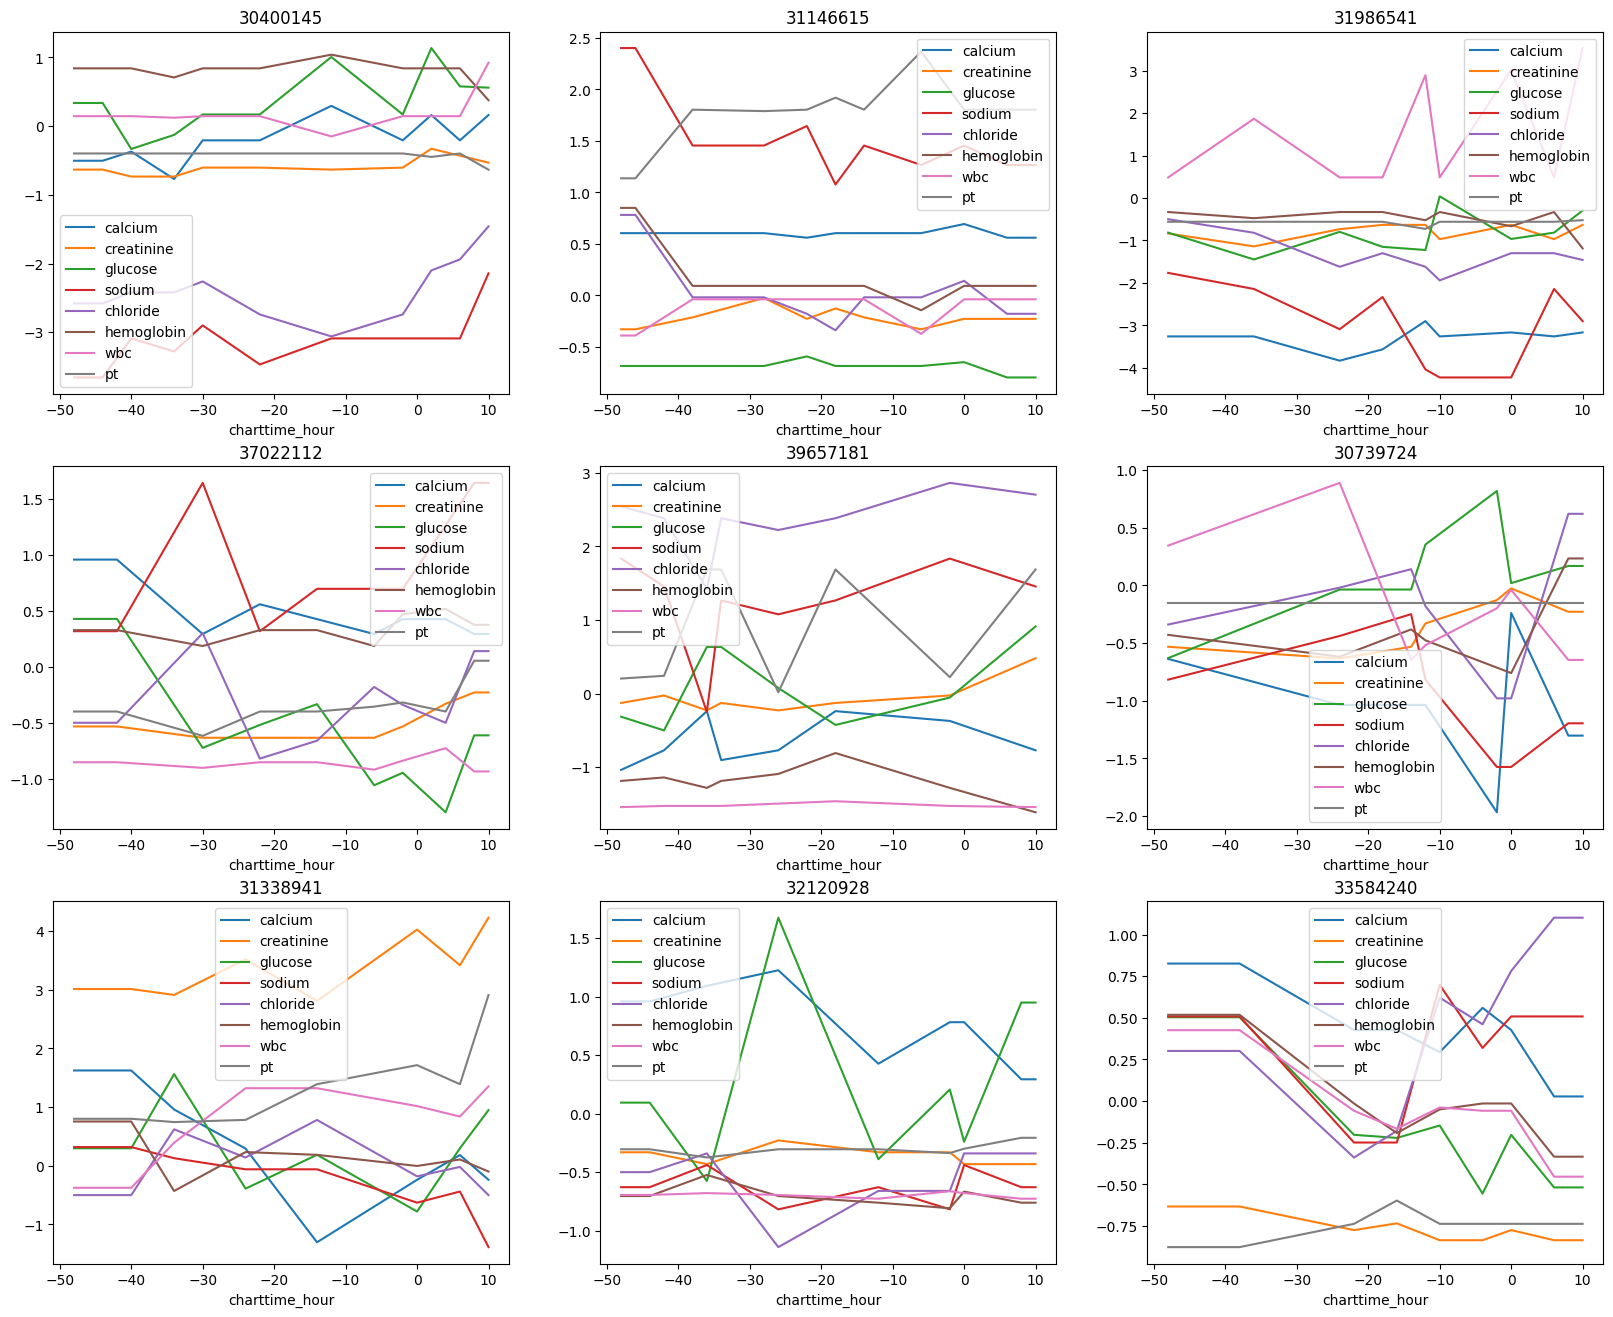

In [4]:
dyn_cols = ['calcium', 'creatinine', 'glucose',
            'sodium', 'chloride', 'hemoglobin', 'wbc', 'pt']
# 取出c每个item的第一个元素，即stay_id
multi_time_id = [item[0] for item in sorted(
    train_X_dict_num.items(), key=lambda x: x[1], reverse=True)[:9]]
# multi_time_id

# 遍历multi_time_id，绘制每个stay_id的图，3*3排列
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
for i, stay_id in enumerate(multi_time_id):
    ax = axes[i//3, i % 3]
    train_X_dict_time_series[stay_id].plot(
        x="charttime_hour", y=dyn_cols, ax=ax)
    ax.set_title(stay_id)
    ax.set_xlabel('charttime_hour')


# vent_start

In [5]:
train_X_df = pd.DataFrame({'stay_id': df_train_static['stay_id'].values})
for key in train_X_dict_time_series.keys():
    train_X_df.loc[train_X_df['stay_id'] == key,
                   feature_column_list] = train_X_dict_time_series[key].iloc[-1, :][1:].values


train_y_df = df_train_static[['stay_id', 'vent_start_hour_1']]

test_X_df = pd.DataFrame(columns=['stay_id', *feature_column_list])
test_X_df['stay_id'] = df_test_static[['stay_id']]
for key in test_X_dict_time_series.keys():
    test_X_df.loc[test_X_df['stay_id'] == key,
                  feature_column_list] = test_X_dict_time_series[key].iloc[-1, :][1:].values
test_y_df = df_test_static[['stay_id', 'vent_start_hour_1']]


In [6]:
train_X_df = pd.merge(df_static, train_X_df, on='stay_id')
test_X_df = pd.merge(df_static, test_X_df, on='stay_id')

dataframes = [train_X_df, train_y_df, test_X_df, test_y_df]
for df in dataframes:
    df.fillna(df.median(), inplace=True)

tensors = [torch.tensor(df.iloc[:, 1:].values.astype(float)) for df in dataframes]

train_X, train_y, test_X, test_y= tensors
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
import torch
import torch.nn as nn


batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_size, hidden_lay1, hidden_lay2,  hidden_lay3, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_lay1)
        self.relu1 = nn.ReLU()
        self.dp = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_lay1, hidden_lay2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_lay2)
        self.fc3 = nn.Linear(hidden_lay2, hidden_lay3)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(hidden_lay3)
        self.fc4 = nn.Linear(hidden_lay3, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dp(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.bn3(out)
        out = self.fc4(out)
        return out

# Define the network
input_size = 19
hidden_lay1 = 32
hidden_lay2 = 32
hidden_lay3 = 64
num_classes = 1
net = Net(input_size, hidden_lay1, hidden_lay2, hidden_lay3, num_classes)
print(net)


Net(
  (fc1): Linear(in_features=19, out_features=32, bias=True)
  (relu1): ReLU()
  (dp): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (relu3): ReLU()
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# Define the loss function and optimization function
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.6)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

epocn_list=[]
running_loss_list=[]

# Define the training loop
num_epochs = 500
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %
                (epoch + 1, running_loss / 100))
        epocn_list.append(epoch)
        running_loss_list.append(running_loss)
        running_loss = 0.0
        
print('Finished Training')
            

[1] loss: 679.815
[11] loss: 484.533
[21] loss: 177.033
[31] loss: 122.068
[41] loss: 120.138
[51] loss: 117.960
[61] loss: 116.742
[71] loss: 117.823
[81] loss: 116.584
[91] loss: 118.009
[101] loss: 117.134
[111] loss: 116.564
[121] loss: 116.805
[131] loss: 116.197
[141] loss: 116.416
[151] loss: 115.861
[161] loss: 115.814
[171] loss: 113.330
[181] loss: 114.864
[191] loss: 111.934
[201] loss: 113.026
[211] loss: 111.682
[221] loss: 112.379
[231] loss: 111.840
[241] loss: 109.549
[251] loss: 110.369
[261] loss: 109.700
[271] loss: 111.507
[281] loss: 109.937
[291] loss: 110.441
[301] loss: 110.173
[311] loss: 109.588
[321] loss: 109.399
[331] loss: 107.045
[341] loss: 109.146
[351] loss: 107.468
[361] loss: 105.860
[371] loss: 105.843
[381] loss: 105.369
[391] loss: 107.138
[401] loss: 106.478
[411] loss: 104.233
[421] loss: 106.462
[431] loss: 104.383
[441] loss: 101.179
[451] loss: 106.581
[461] loss: 104.667
[471] loss: 100.644
[481] loss: 100.642
[491] loss: 99.357
Finished Tra

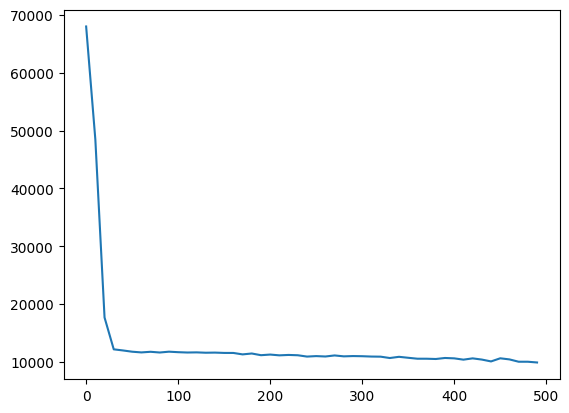

In [9]:
plt.plot(epocn_list,running_loss_list)
plt.show()

In [10]:
pred_y = net(test_X.float()).detach().numpy()
gt_y=test_y.float().detach().numpy()
L1_abs_err = np.mean(abs(pred_y - gt_y))
MSE  = np.mean((pred_y - gt_y )**2)
print('===================  VENTILATION START TIME  with Static EHR ============================= ')
print('Mean L1 error:', np.round(L1_abs_err, 2))
print('Mean Square error:', np.round(MSE))


print('================  VENTILATION START TIME in 1,2,6,12,24 with Static EHR ==================== ')
gt_y = df_test_static[['vent_start_hour_1','vent_start_hour_2','vent_start_hour_6','vent_start_hour_12','vent_start_hour_24']].values
h_list=[1, 2, 6, 12, 24]
divisors = np.array([h_list]).reshape(1, -1)
pred_divided = pred_y.reshape(-1,1) // divisors
accuracies = np.mean(pred_divided == gt_y, axis=0) * 100
for i, h in enumerate(h_list):
    print('Accuracy at {} hours : {:.2f} %'.format(h,accuracies[i]))

===================  VENTILATION START TIME  with Static EHR ============================= 
Mean L1 error: 10.9
Mean Square error: 175.0
================  VENTILATION START TIME in 1,2,6,12,24 with Static EHR ==================== 
Accuracy at 1 hours : 2.14 %
Accuracy at 2 hours : 5.44 %
Accuracy at 6 hours : 16.31 %
Accuracy at 12 hours : 29.51 %
Accuracy at 24 hours : 42.91 %
